### In this notebook i gather datasets and prepare ML model

Read dataset from other notebooks

In [723]:
%store -r df_rel #other
%store -r data #prices
%store -r df  #loans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler


no stored variable or alias #other
no stored variable or alias #prices
no stored variable or alias #loans


Time to join our dataframes. Because loan info is global for Poland I have decided not to split statistics among regions. I will group regions and find the mean of the values i df_rel and data dataframes.


In [724]:
df_rel['Mean_price'] = df_rel.mean(axis=1)

In [725]:
df_rel = df_rel['Mean_price'].to_frame()
df_rel

,Mean_price
date,
2006-10-01,593.619976
2007-01-01,682.689077
2007-04-01,645.813428
2007-07-01,-12.703526
2007-10-01,87.677613
...,...
2021-10-01,299.553089
2022-01-01,278.889970
2022-04-01,390.800201


Same for data dataframe, lets group by year and find mean of different values.

In [726]:
data

,year,Building_permissions,region,flats_sold,Mean_earnings
0,2005,226.0,DOLNOŚLĄSKIE,NaN,2507.77
1,2006,388.0,DOLNOŚLĄSKIE,NaN,2604.41
2,2007,605.0,DOLNOŚLĄSKIE,NaN,2847.92
3,2008,444.0,DOLNOŚLĄSKIE,NaN,3120.42
4,2009,331.0,DOLNOŚLĄSKIE,NaN,3332.46
...,...,...,...,...,...
175,2018,322.0,ŚLĄSKIE,535.0,4811.88
176,2019,264.0,ŚLĄSKIE,825.0,5206.73
177,2020,309.0,ŚLĄSKIE,795.0,5549.14
178,2021,424.0,ŚLĄSKIE,1184.0,5908.69


In [727]:
data = data.groupby('year').mean()
data

/tmp/ipykernel_2831/622920816.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby('year').mean()


,Building_permissions,flats_sold,Mean_earnings
year,,,
2005,124.7,NaN,2400.155
2006,196.1,NaN,2506.910
2007,273.1,NaN,2698.140
2008,244.4,NaN,2974.223
2009,161.9,NaN,3183.854
2010,164.1,583.1,3327.473
2011,167.4,504.7,3457.593
2012,159.8,697.2,3644.457
2013,129.1,855.5,3732.228


Change index type to datetime

In [728]:
data.index = pd.to_datetime(data.index, format='%Y')
data = data.reset_index()

In [729]:
#create temporary dataframes as a copy, for new quaters for each year
data2 = data.copy()
data2['year'] = data2['year'] + pd.DateOffset(months=3)
data3 = data2.copy()
data3['year'] = data3['year'] + pd.DateOffset(months=3)
data4 = data3.copy()
data4['year'] = data4['year'] + pd.DateOffset(months=3)

In [730]:
#join dataframes so we have for quaters for each year with same values
data = pd.concat([data, data2, data3, data4], ignore_index=True)

In [731]:
#set index back to years
data = data.set_index('year', drop=True)

Set index as date for df dataframe

In [732]:
df = df.set_index('Date', drop=True)

## Now we are ready to join tables.  

---


#### Because I have unified inxes, I can use simple concat.

In [733]:
print(f'df: {len(df)}')
print(f'df_rel: {len(df_rel)}')
print(f'data: {len(data)}')

df: 77
df_rel: 65
data: 72


In [734]:
df = pd.concat([df,df_rel,data], axis=1)

### Right now we have a lot of Nans. For Mean price our first values are from the 2006-10-01 so i will remove data from earlier quarters.

In [735]:
df.isnull().sum()

Loan_forcast             0
Changes_expenses         0
Alt_finansing            0
Change_economy           0
Change_rules             0
Change_criteria          0
Change_Others            0
Mean_price              12
Building_permissions     9
flats_sold              29
Mean_earnings            5
dtype: int64

In [736]:
#quick check in the middle of dataframe
df = df[df.index >= '2006-10-01']

### Flats sold column has to many Nan values, I have decided to drop it.

In [737]:
df = df.drop('flats_sold', axis=1)

#### Building permissions after additional checks looks the same as year before so i copy the data

In [738]:
df.loc['2022-01-01','Building_permissions'] = 275.1
df.loc['2022-04-01','Building_permissions'] = 275.1
df.loc['2022-07-01','Building_permissions'] = 275.1
df.loc['2022-10-01','Building_permissions'] = 275.1


In [739]:
df.isnull().sum()

Loan_forcast            0
Changes_expenses        0
Alt_finansing           0
Change_economy          0
Change_rules            0
Change_criteria         0
Change_Others           0
Mean_price              0
Building_permissions    0
Mean_earnings           0
dtype: int64

Normalize data

In [740]:
df['Mean_earnings'] = df['Mean_earnings']/1000
df['Building_permissions'] = df['Building_permissions']/100

In [741]:
df

,Loan_forcast,Changes_expenses,Alt_finansing,Change_economy,Change_rules,Change_criteria,Change_Others,Mean_price,Building_permissions,Mean_earnings
2006-10-01,0.459571,0.102619,0.057329,0.227095,-0.059210,-0.059210,-0.201830,593.619976,1.961,2.506910
2007-01-01,0.051655,0.010503,-0.013283,0.010610,-0.152480,0.000000,0.041065,682.689077,2.731,2.698140
2007-04-01,0.474374,0.173030,0.009273,0.081695,0.213050,0.057590,0.124592,645.813428,2.731,2.698140
2007-07-01,-0.034746,0.029907,-0.015242,0.029907,-0.091528,-0.044180,0.013231,-12.703526,2.731,2.698140
2007-10-01,-0.317761,-0.001447,-0.027697,0.014945,0.012805,0.006403,-0.053894,87.677613,2.731,2.698140
...,...,...,...,...,...,...,...,...,...,...
2021-10-01,-0.157503,-0.145476,-0.035757,-0.144237,-0.107572,-0.019827,-0.173835,299.553089,2.751,5.708551
2022-01-01,-0.282905,-0.466923,-0.075526,-0.495623,-0.092373,-0.113838,-0.567222,278.889970,2.751,6.267094
2022-04-01,-0.473571,-0.508385,-0.133011,-0.564630,-0.411703,-0.489879,-0.180321,390.800201,2.751,6.267094
2022-07-01,-0.549571,-0.440012,-0.119988,-0.638404,-0.223493,-0.184307,-0.396302,327.510803,2.751,6.267094


___
___
___
# Create new features

I will add new column with quarter and year.

In [742]:
df['Quarter'] = df.index.quarter
df['Year'] = df.index.year

Lets rearrange columns, so that target is last one, just for clear view.

In [743]:
df = df[['Quarter', 'Year','Loan_forcast', 'Alt_finansing', 'Changes_expenses', 'Change_economy',
       'Change_rules', 'Change_criteria', 'Change_Others',
       'Building_permissions', 'Mean_earnings', 'Mean_price']]

---
---
---
# THE MODEL

XGBOOST

In [744]:
df

,Quarter,Year,Loan_forcast,Alt_finansing,Changes_expenses,Change_economy,Change_rules,Change_criteria,Change_Others,Building_permissions,Mean_earnings,Mean_price
2006-10-01,4,2006,0.459571,0.057329,0.102619,0.227095,-0.059210,-0.059210,-0.201830,1.961,2.506910,593.619976
2007-01-01,1,2007,0.051655,-0.013283,0.010503,0.010610,-0.152480,0.000000,0.041065,2.731,2.698140,682.689077
2007-04-01,2,2007,0.474374,0.009273,0.173030,0.081695,0.213050,0.057590,0.124592,2.731,2.698140,645.813428
2007-07-01,3,2007,-0.034746,-0.015242,0.029907,0.029907,-0.091528,-0.044180,0.013231,2.731,2.698140,-12.703526
2007-10-01,4,2007,-0.317761,-0.027697,-0.001447,0.014945,0.012805,0.006403,-0.053894,2.731,2.698140,87.677613
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01,4,2021,-0.157503,-0.035757,-0.145476,-0.144237,-0.107572,-0.019827,-0.173835,2.751,5.708551,299.553089
2022-01-01,1,2022,-0.282905,-0.075526,-0.466923,-0.495623,-0.092373,-0.113838,-0.567222,2.751,6.267094,278.889970
2022-04-01,2,2022,-0.473571,-0.133011,-0.508385,-0.564630,-0.411703,-0.489879,-0.180321,2.751,6.267094,390.800201
2022-07-01,3,2022,-0.549571,-0.119988,-0.440012,-0.638404,-0.223493,-0.184307,-0.396302,2.751,6.267094,327.510803


In [745]:
columns = df.columns
covariates = columns[:-1]
covariates

Index(['Quarter', 'Year', 'Loan_forcast', 'Alt_finansing', 'Changes_expenses',
       'Change_economy', 'Change_rules', 'Change_criteria', 'Change_Others',
       'Building_permissions', 'Mean_earnings'],
      dtype='object')

In [746]:


# Create a TimeSeries for target
series = TimeSeries.from_dataframe(df['Mean_price'].to_frame())

# Create a TimeSeries for covariates
series_cov = TimeSeries.from_dataframe(df[covariates])

# Set aside the last 12 months as a validation series
train, val = series[:-12], series[-12:]
train_cov, val_cov = series_cov[:-12], series_cov[-12:]

# Scale variables
scaler_ = Scaler()
train = scaler_.fit_transform(train)
val = scaler_.transform(val)
scaler_2 = Scaler()
train_cov = scaler_2.fit_transform(train_cov)
val_cov = scaler_2.transform(val_cov)

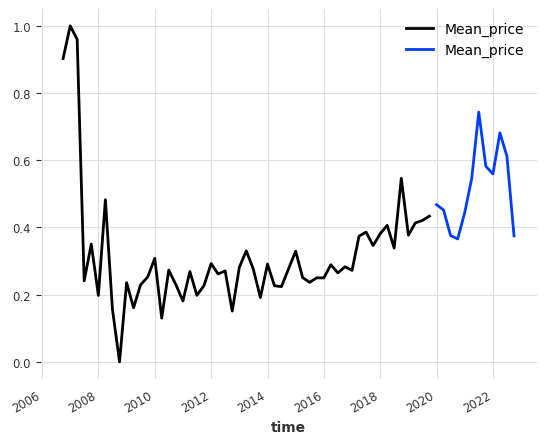

In [747]:
train.plot()
val.plot()
plt.show()

Number of components is larger than 10 (11). Plotting only the first 10 components.
Number of components is larger than 10 (11). Plotting only the first 10 components.


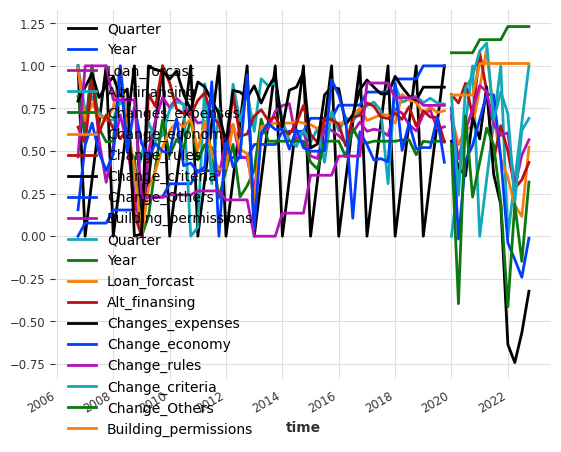

In [748]:
train_cov.plot()
val_cov.plot()
plt.show()

In [749]:
from darts.models import BlockRNNModel

model_pastcov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=40,
    output_chunk_length=12,
    n_epochs=1000,
    random_state=0,
)

In [750]:
model_pastcov.fit(
    series=train,
    past_covariates=train_cov,
    verbose=True,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 3.9 K 
4 | fc            | Sequential       | 312   
---------------------------------------------------
4.2 K     Trainable params
0         Non-trainable params
4.2 K     Total params
0.034     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

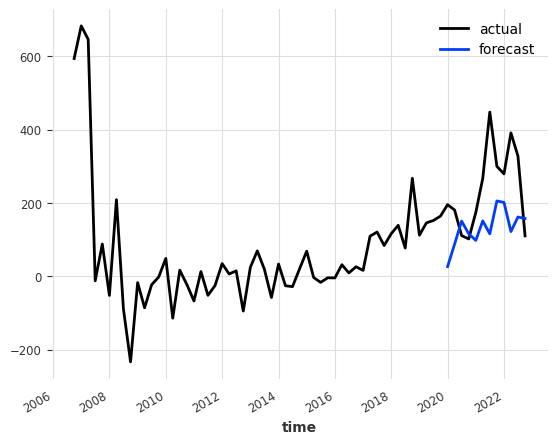

In [751]:
#predict values
pred_cov = model_pastcov.predict(n=12, series=train, past_covariates=train_cov)

#inverse transform
pred_cov = scaler_.inverse_transform(pred_cov)

series.plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend()

Could be better, could be worse.

___
___
___
### TIME TO PREDICT THE FUTURE VALUES

I will use whole dataset to train the model

In [754]:
# Set aside the last 12 months as a validation series
train = series.copy()
train_cov = series_cov.copy()

# Scale variables
scaler_ = Scaler()
train = scaler_.fit_transform(train)

scaler_2 = Scaler()
train_cov = scaler_2.fit_transform(train_cov)

In [764]:
model = BlockRNNModel(
    model="LSTM",
    input_chunk_length=50,
    output_chunk_length=12,
    n_epochs=1000,
    random_state=0,
)

In [765]:
model.fit(
    series=train,
    past_covariates=train_cov,
    verbose=True,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 3.9 K 
4 | fc            | Sequential       | 312   
---------------------------------------------------
4.2 K     Trainable params
0         Non-trainable params
4.2 K     Total params
0.034     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

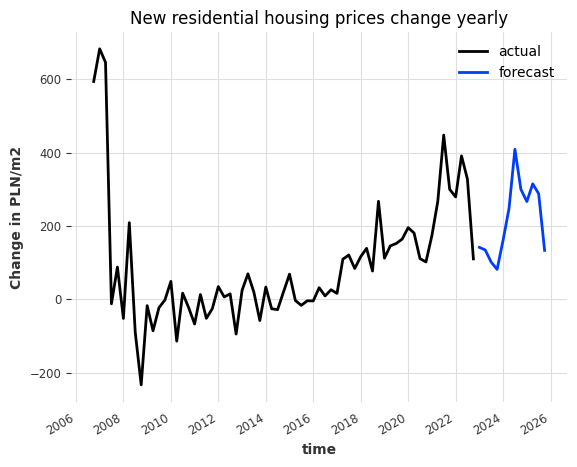

In [770]:
#predict values
pred_cov = model.predict(n=12, series=train, past_covariates=train_cov)

#inverse transform
pred_cov = scaler_.inverse_transform(pred_cov)

series.plot(label="actual")
pred_cov.plot(label="forecast")
plt.ylabel('Change in PLN/m2')
plt.title('New residential housing prices change yearly')
plt.legend()

#This graph shows the change in prices in PLN/m2 average in Poland for flats in new residential housing.